In [111]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [112]:
%matplotlib inline

In [113]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['figure.dpi'] = 150

In [114]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [115]:
import Actuator_force as af

In [116]:
af.print_stats()

F_nut: 419.59104655824115
F_act: 516.5249561399658
w_max: 83.23722746051511
theta_min: 5.46502379990588
E_ratio: 8.181491291246676
Min Length: 35.19911713737767
Max Length: 196.20703583268897
I_stage1: 0.8630697997090299
I_stage2: 0.9022791988361196
I_base: 2.6153489985451497
alpha: 0.15707963267948966
F_app Grav Approximation: 32.1003280330555
Peak Motor Torque Requirement: 0.9179379950081881


In [117]:
af.w_l(af.L_max, af.l_bent, af.l_r, af.l_total)

24.049483010402337

In [118]:
def plot_w(l_b, l_o):
    l = np.arange(af.L_min, af.L_max, 1)
    w = [af.w_l(L, l_b, l_o, af.l_total) for L in l]
    plt.plot(w,l)
interact(plot_w, l_b = (0, 15, 0.5), l_o = (af.l_r/1.5, af.l_r*1.5, 1) )

interactive(children=(FloatSlider(value=7.0, description='l_b', max=15.0, step=0.5), FloatSlider(value=45.0, d…

<function __main__.plot_w(l_b, l_o)>

In [119]:
def plot_L_theta(l_b, l_o, colour):
    l_total = af.l_r*4 + l_o
    
    for i in np.linspace(af.theta_min(l_o), np.pi/2):
        w_min =  af.w_theta(i, l_o, l_total)
        if w_min<af.w_min:
            theta_max = i
            break

    theta = np.arange(af.theta_min(l_o), theta_max, 0.01)
    w = [af.w_theta(th, l_o, l_total) for th in theta]
    l  = [af.L_theta(th, l_b, l_total) for th in theta]
    plt.plot(w,l, color = colour)
    return l,w,theta
# interact(plot_L_theta, l_b = (0, 15, 0.5), l_o = (af.l_r/1.5, af.l_r*1.5, 1), colour = 'r' )

Text(0.5, 0, 'Width (mm)')

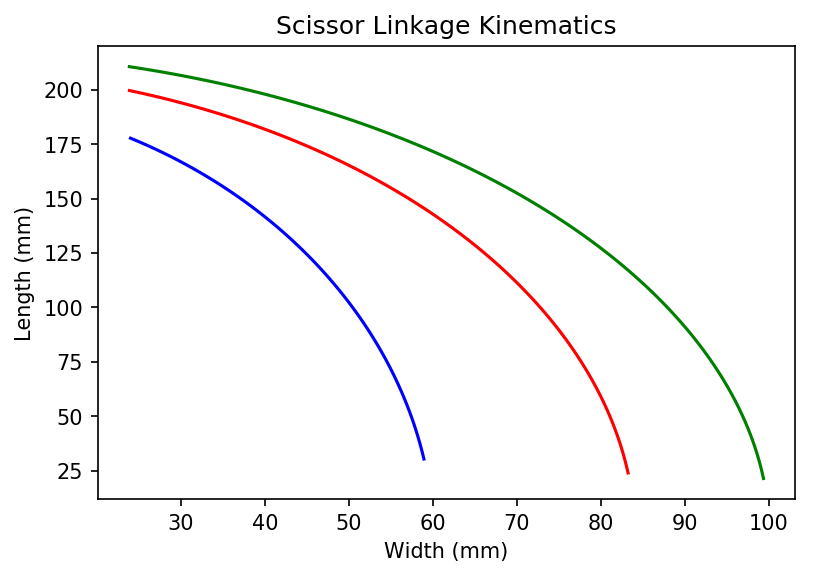

In [120]:
l1, w1, theta1 = plot_L_theta(4, 42, 'r')
l2, w2, theta2 = plot_L_theta(4, 30, 'b')
l3, w3, theta3 = plot_L_theta(4, 50, 'g')
plt.title("Scissor Linkage Kinematics")
plt.ylabel("Length (mm)")
plt.xlabel("Width (mm)")
# plt.savefig("ScissorK.png")

-25.291064727148633
5.018997996950809


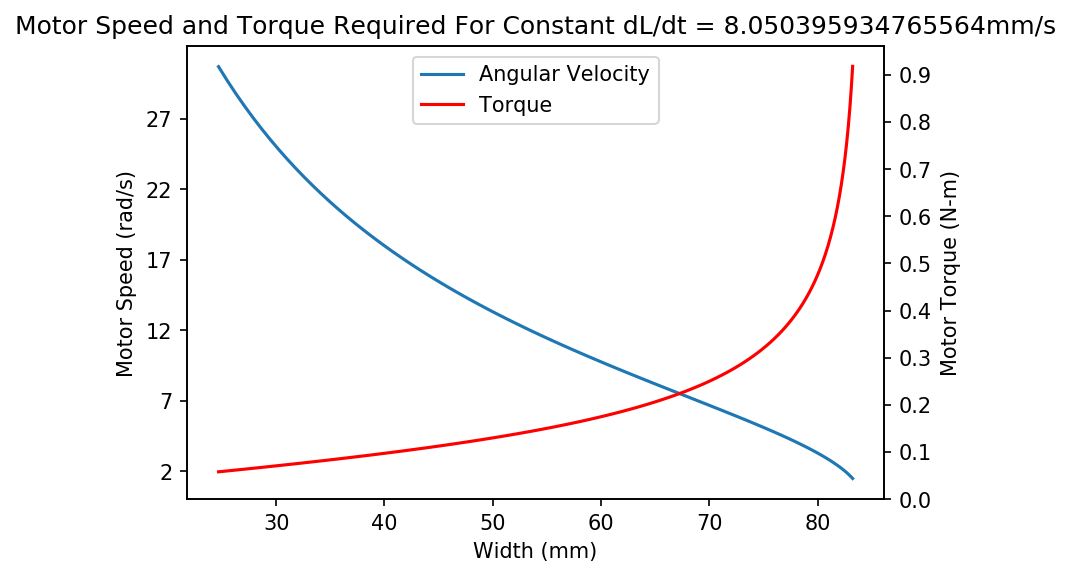

In [121]:
def plot_dtheta_dt(ax, l, w, dL_dt):
    dtheta_dt = []
    k = -dL_dt*np.pi/(af.lead*1000)
    print(k)
    for i in range(len(l) - 1):
        dtheta_dt.append( k*(w[i+1] - w[i])/(l[i+1] - l[i]) )
    ln = ax.plot(w[0:-1], dtheta_dt, label  = "Angular Velocity")
    plt.yticks(np.arange( round(min(dtheta_dt)), round(max(dtheta_dt)+1), 5.0))
    return dtheta_dt, ln

def plot_T_motor(ax, theta, w):
    T = []
    for i in range(len(theta) - 1):
        T.append( af.T_motor(theta[i], af.F_app, af.l_bent, af.l_r, af.l_total))
    
    ln = ax.plot(w[0:-1], T, 'r', label = "Torque")
    plt.yticks(np.arange( round(min(T)), round(max(T)+0.1), 0.1))
    return T, ln



fig, ax1 = plt.subplots()


dL_dt = (af.L_max - af.L_min)/20.0 #mm/s
plt.xlabel("Width (mm)")
plt.ylabel("Motor Speed (rad/s)")
dtheta_dt, ln1 = plot_dtheta_dt(ax1, l1,w1, dL_dt);

ax2 = ax1.twinx()
plt.ylabel("Motor Torque (N-m)")


T_motor, ln2 = plot_T_motor(ax2, theta1, w1)
lines = ln1+ln2
labels = [ln.get_label() for ln in lines]
ax1.legend(lines, labels, loc = 9)

plt.title("Motor Speed and Torque Required For Constant dL/dt = " + str(dL_dt) + "mm/s")
plt.savefig("const_speed_torque.png")


#calculating power of constant velocity trajectory
power = 0
for i in range(len(dtheta_dt) - 1):
    power+=T_motor[i]*(dtheta_dt[i+1] -dtheta_dt[i] )
    
print(power)

Text(0.5, 1.0, 'Torque-Speed Curve')

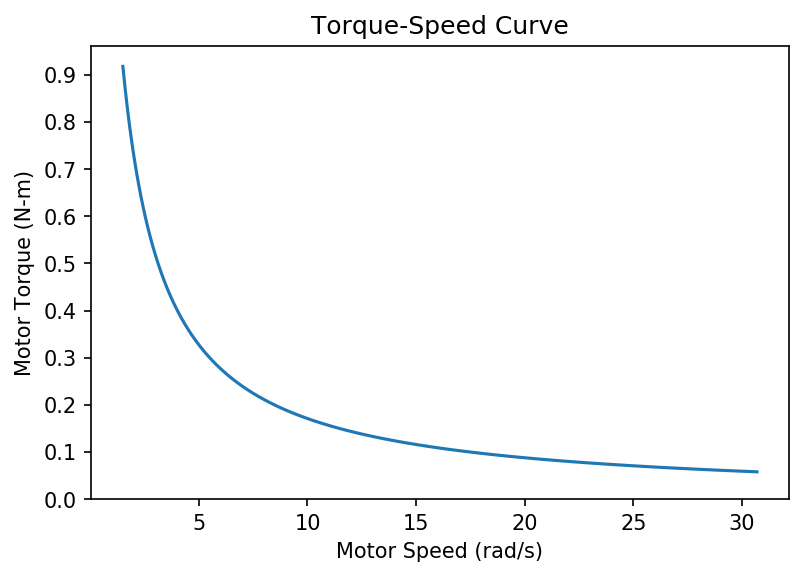

In [122]:
plt.plot(dtheta_dt,T_motor)
plt.yticks(np.arange( round(min(T_motor)), round(max(T_motor)+0.1), 0.1))
plt.ylabel("Motor Torque (N-m)")
plt.xlabel("Motor Speed (rad/s)")
plt.title("Torque-Speed Curve")

Text(0.5, 1.0, 'Motor Power Required for dL/dt = 8.050395934765564(mm/s)')

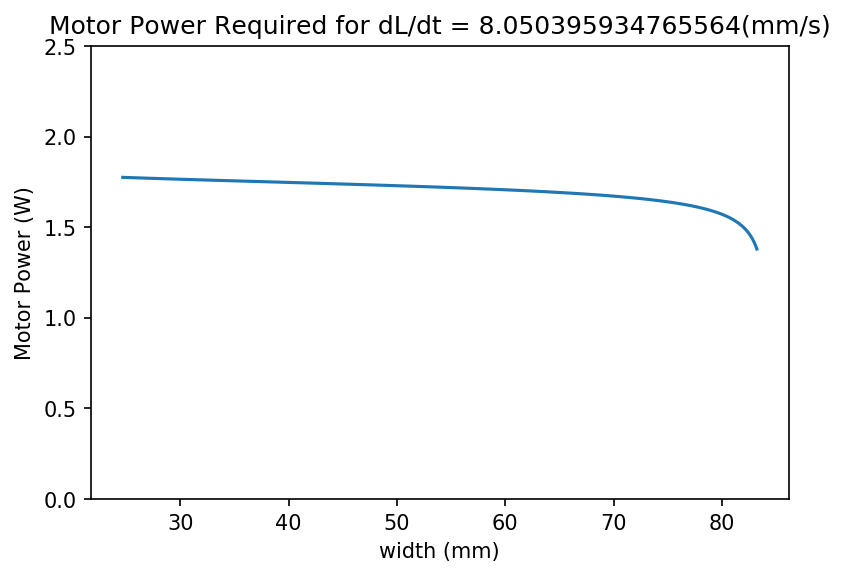

In [123]:
# Power Plot
P = [] 
for i in range(len(T_motor)):
    P.append(T_motor[i]*dtheta_dt[i])
plt.plot(w1[0:-1], P)
plt.xlabel("width (mm)")
plt.ylim(0, 2.5)
plt.ylabel("Motor Power (W)")
plt.title("Motor Power Required for dL/dt = "+ str(dL_dt) + "(mm/s)")

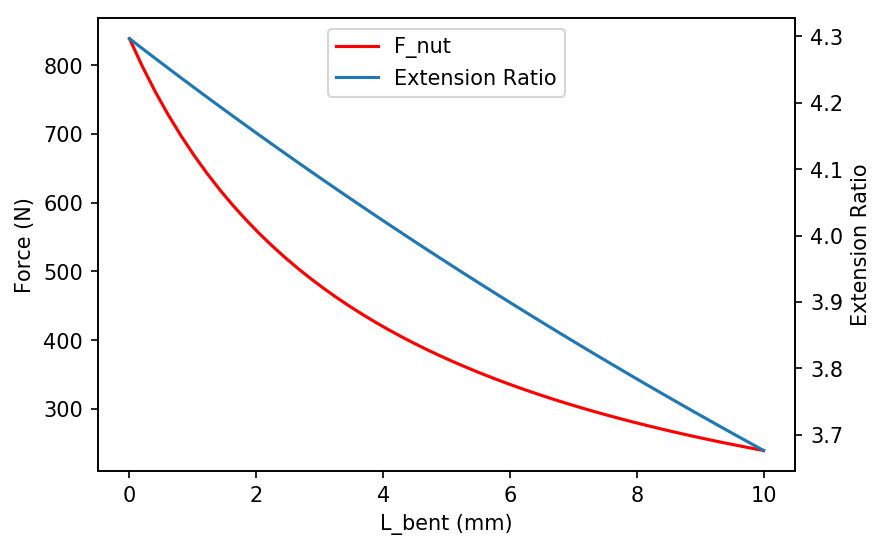

In [124]:
#L_bent curve
fig, ax1 = plt.subplots()

lb = np.linspace(0, 10)
F = [af.F_nut(af.theta_min(af.l_r),af.F_app, l_b, af.l_r, af.l_total ) for l_b in lb]

ln1 = ax1.plot(lb, F, label = 'F_nut', color ='r')
plt.xlabel("L_bent (mm)")
plt.ylabel("Force (N)")

ax2 = ax1.twinx()
offset = 33 #mm
E_ratio = [af.E_ratio(l_b, af.l_r, af.l_total, offset) for l_b in lb]
ln2 = ax2.plot(lb, E_ratio, label = 'Extension Ratio')


lines = ln1+ln2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc = 9)
plt.ylabel("Extension Ratio")
plt.savefig("e_ratio_force_bent.png")




In [125]:
af.theta_w(83.23, 4, 42)/np.pi*180

5.499512638694658

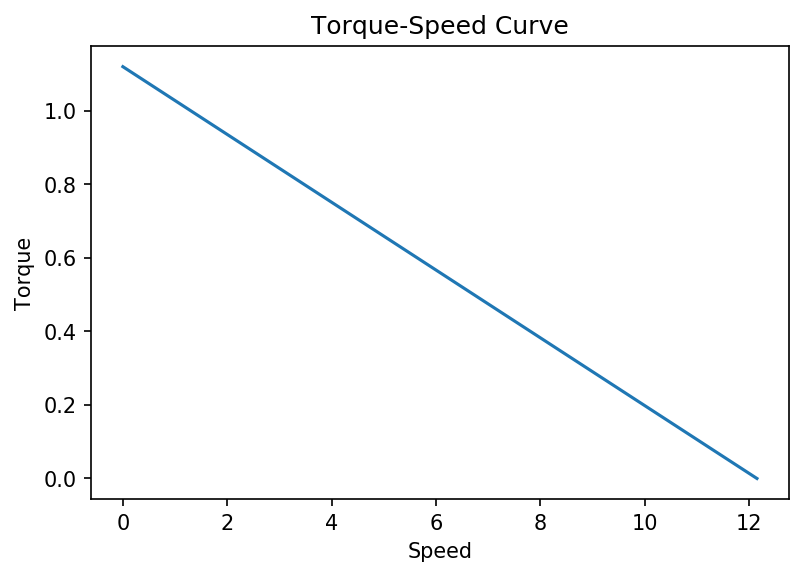

In [126]:
def plot_motor_param(ax1, T_stall, w_noload, label = None):
    w = np.linspace(0,w_noload)
    T = np.array([-(T_stall/w_noload)*ww+ T_stall for ww in w])
    ax1.plot(w,T, label = label)

#     P = w*T
#     ax2 = ax1.twinx()
#     ax2.plot(w,P,'r')

    
fig, ax1 = plt.subplots()

# ax1.plot(dtheta_dt,T_motor)
# plt.yticks(np.arange( round(min(T_motor)), round(max(T_motor)+0.1), 0.1))
plt.ylabel("Torque")
plt.xlabel("Speed")
plt.title("Torque-Speed Curve")

T_stall = 1.12 #N-m
w_noload = (116/60.0)*2*np.pi #rad/s
plot_motor_param(ax1, T_stall, w_noload)


time to rise: 20.54
35.19911713737767
35.19911713737767
196.20703583268897


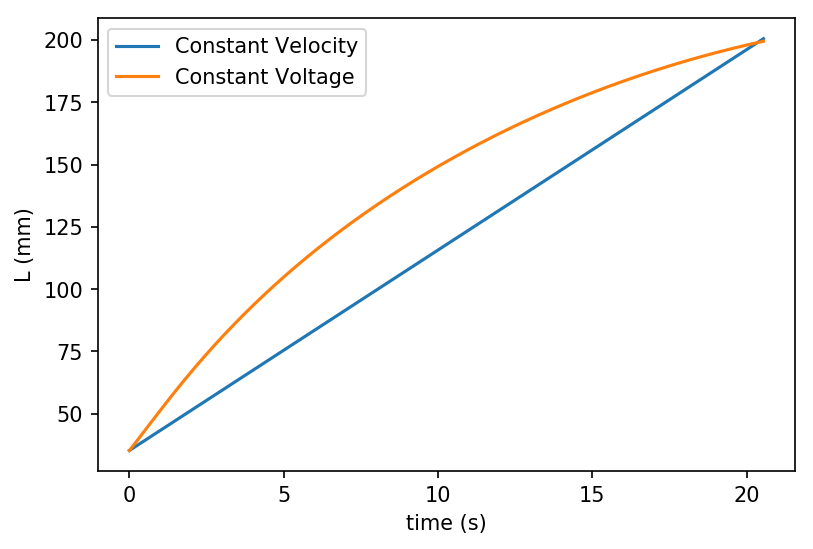

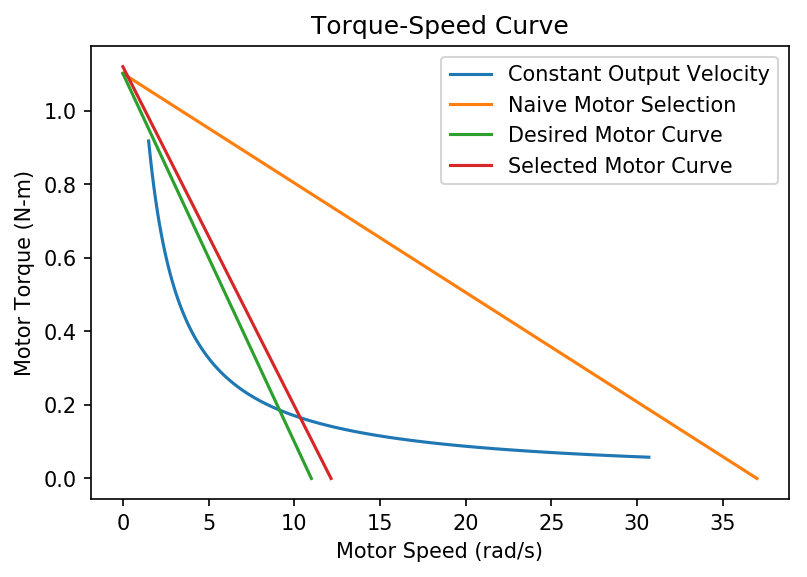

In [129]:
w_noload_trial = 11
t, phi_list = af.sim_phi(w_noload_trial, 0.01)
fig1, axis = plt.subplots()


axis.plot([ i*0.01 for i in range(len(phi_list))], [af.L_min+ 0.01*i*dL_dt for i in range(len(phi_list))], label = "Constant Velocity")
axis.plot([ i*0.01 for i in range(len(phi_list))],[af.L_phi(phi) for phi in phi_list], label = "Constant Voltage")
plt.ylabel("L (mm)")
plt.xlabel("time (s)")
axis.legend()


fig, ax = plt.subplots()
print("time to rise: " + str(t))
print(af.L_phi(0))
print(af.L_theta(af.theta_w(af.w_max)) )
print(af.L_max)

ax.plot(dtheta_dt,T_motor, label = "Constant Output Velocity")
plot_motor_param(ax, af.T_stall, 37, "Naive Motor Selection")
plot_motor_param(ax, af.T_stall, w_noload_trial, "Desired Motor Curve")
plot_motor_param(ax, T_stall, w_noload, "Selected Motor Curve")
# plt.yticks(np.arange( round(min(T_motor)), round(max(T_motor)+0.1), 0.1))
plt.ylabel("Motor Torque (N-m)")
plt.xlabel("Motor Speed (rad/s)")
plt.title("Torque-Speed Curve")
plt.legend()
# plt.savefig("selected.png")

In [103]:
%autoreload